# Framework
1. Analyse Lyrics - Bert based, Hatebert, senwave bert
2. Analyse beat - Tempo, rhythm, chord, key, structure, spectral, loudness, visualizations
3. Participant section - 

In [156]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from collections import Counter
from nltk.util import ngrams
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertForSequenceClassification, BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors


In [129]:
nltk.download('punkt')
nltk.download('stopwords')
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lyric Analysis - Kanye

In [130]:
df = pd.DataFrame(columns=["song_title", "song_lyrics"])

In [131]:
def censor_words(tokens):  # renamed 'text' to 'tokens' to be clearer
    word_censor = {
        "nigga": "n*gga",
        "nigger": "n*gger",
        "anal": "@n@l",
        "booty": "b**ty",
        "pussy": "p*ssy",
        "sex": "s*x",
        "niggas": "n*ggas"
    }
    return [word_censor.get(word, word) for word in tokens]

def clean_lyrics(text, include_labels=False):
    if include_labels:
        text = re.sub(r"(?<!\[)[\"'(),{}\]?](?!])", "", text)
    else:
        text = re.sub(r"\[.*?\]", "", text)
        text = re.sub(r"[\"'(),\[\]{}?]", "", text)

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = censor_words(tokens)  # Assuming you defined this elsewhere

    return tokens

In [132]:
def create_ngram_df(lyrics, artist):
    ngram_df = pd.DataFrame(columns=["ngram", "freq", "ngram_type"])
    bigram = Counter(list(ngrams(lyrics, 2)))
    trigram = Counter(list(ngrams(lyrics, 3)))
    for bi, freq in bigram.items():
        ngram_df = pd.concat([pd.DataFrame([[bi, freq, "bigram"]], columns=ngram_df.columns), ngram_df], ignore_index=True)
    for tri, freq in trigram.items():
        ngram_df = pd.concat([pd.DataFrame([[tri, freq, "trigram"]], columns=ngram_df.columns), ngram_df], ignore_index=True)
    ngram_df['artist'] =  artist
    return ngram_df

In [133]:
def get_top_ngrams(df):
    top_10_bigrams = df[df['ngram_type'] == "bigram"].sort_values("freq", ascending=False).head(10)
    top_10_trigrams = df[df['ngram_type'] == "trigram"].sort_values("freq", ascending=False).head(10)
    return top_10_bigrams, top_10_trigrams

# Lyric Analysis - Cardi B

In [134]:
def read_lyrics(artists=["Kanye West", "Cardi B", "Elton John", "Tom Macdonald"]):
    lyrics = {}
    for i, artist in enumerate(artists, start=1):
        with open(f"./song{i}/lyrics.txt", "r", encoding="utf-8") as f:
            contents = f.read()
        lyrics[artist] = contents
    return lyrics



def create_df():
    res = pd.DataFrame(columns=["ngram", "freq", "ngram_type", "artist"])
    artist_lyrics = read_lyrics()
    for artist, lyric in artist_lyrics.items():
        ngram_df = create_ngram_df(clean_lyrics(lyric), artist)
        res = pd.concat([res, ngram_df], ignore_index=True)
        
    return res


In [135]:
ngram_df = create_df() # concatenate the songs into one df

In [136]:
ngram_df

,ngram,freq,ngram_type,artist
0,"(hands, n*gga, heil)",1,trigram,Kanye West
1,"(her, hands, n*gga)",1,trigram,Kanye West
2,"(in, her, hands)",1,trigram,Kanye West
3,"(world, in, her)",1,trigram,Kanye West
4,"(the, world, in)",1,trigram,Kanye West
...,...,...,...,...
3128,"(guilty, for)",1,bigram,Tom Macdonald
3129,"(feel, guilty)",1,bigram,Tom Macdonald
3130,"(not, feel)",1,bigram,Tom Macdonald
3131,"(can, not)",1,bigram,Tom Macdonald


In [137]:
ngram_df['rank'] = ngram_df.groupby(['ngram_type', 'artist'])['freq'].rank(method="first", ascending=False)
top_ngrams = ngram_df[ngram_df['rank'] <= 10].drop(columns="rank")

In [138]:
top_ngrams


,ngram,freq,ngram_type,artist
29,"(nazis, n*gga, heil)",3,trigram,Kanye West
30,"(n*ggas, nazis, n*gga)",3,trigram,Kanye West
31,"(my, n*ggas, nazis)",3,trigram,Kanye West
32,"(hitler, all, my)",3,trigram,Kanye West
33,"(heil, hitler, all)",3,trigram,Kanye West
...,...,...,...,...
2948,"(dear, white)",4,bigram,Tom Macdonald
2949,"(boy, dear)",4,bigram,Tom Macdonald
2950,"(black, white)",4,bigram,Tom Macdonald
2965,"(white, boy)",23,bigram,Tom Macdonald


In [139]:
def make_artist_ngram_plot(top_ngrams):
    artists = ["Kanye West", "Cardi B", "Elton John", "Tom Macdonald"]
    
    artist_colors = {
        "Kanye West": ['#48A0C9', '#DF3659'],      
        "Cardi B":    ['#60BD68', '#FAA43A'],      
        "Elton John": ['#B2912F', '#F17CB0'],      
        "Tom Macdonald": ['#DECF3F', '#B276B2'],   
    }
    
    plt.rcParams.update({'font.size': 16})
    
    fig, axes = plt.subplots(len(artists), 2, figsize=(12, 5 * len(artists)), constrained_layout=True)
    
    for i, artist in enumerate(artists):
        bigram = top_ngrams[
            (top_ngrams['artist'] == artist) & 
            (top_ngrams['ngram_type'] == 'bigram')
        ]
        trigram = top_ngrams[
            (top_ngrams['artist'] == artist) & 
            (top_ngrams['ngram_type'] == 'trigram')
        ]
        
        # Plot bigram
        bigram_sorted = bigram.sort_values('freq', ascending=True)
        ax_bigram = axes[i, 0]
        bigram_sorted.plot.barh(
            x='ngram',
            y='freq',
            ax=ax_bigram,
            color=artist_colors[artist][0],
            legend=False,
            **barstyle
        )
        ax_bigram.set_xlabel("Count", fontsize=20)
        ax_bigram.invert_xaxis()
        ax_bigram.grid(True, axis='x', linestyle='--', alpha=0.7)
        ax_bigram.tick_params(axis='y', which='major', labelsize=23)
        ax_bigram.tick_params(axis='x', which='major', labelsize=20)
        ax_bigram.set_title(f"{artist}", fontsize=20, pad=15)
        
        max_val_bigram = bigram_sorted['freq'].max() if not bigram_sorted.empty else 1
        x_ticks = np.linspace(0, max_val_bigram, num=3)
        ax_bigram.set_xticks(x_ticks.astype(int))

        # Plot trigram
        trigram_sorted = trigram.sort_values('freq', ascending=True)
        ax_trigram = axes[i, 1]
        trigram_sorted.plot.barh(
            x='ngram',
            y='freq',
            ax=ax_trigram,
            color=artist_colors[artist][1],
            legend=False,
            **barstyle
        )
        ax_trigram.set_xlabel("Count", fontsize=20)
        ax_trigram.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
        ax_trigram.set_ylabel("")
        ax_trigram.grid(True, axis='x', linestyle='--', alpha=0.7)
        ax_trigram.tick_params(axis='y', which='major', labelsize=23)
        ax_trigram.tick_params(axis='x', which='major', labelsize=20)
        ax_trigram.set_title(f"{artist}", fontsize=20, pad=15)
        
        max_val_trigram = trigram_sorted['freq'].max() if not trigram_sorted.empty else 1
        x_ticks = np.linspace(0, max_val_trigram, num=3)
        ax_trigram.set_xticks(x_ticks.astype(int))
        
        sns.despine(bottom=True)
    
    plt.show()

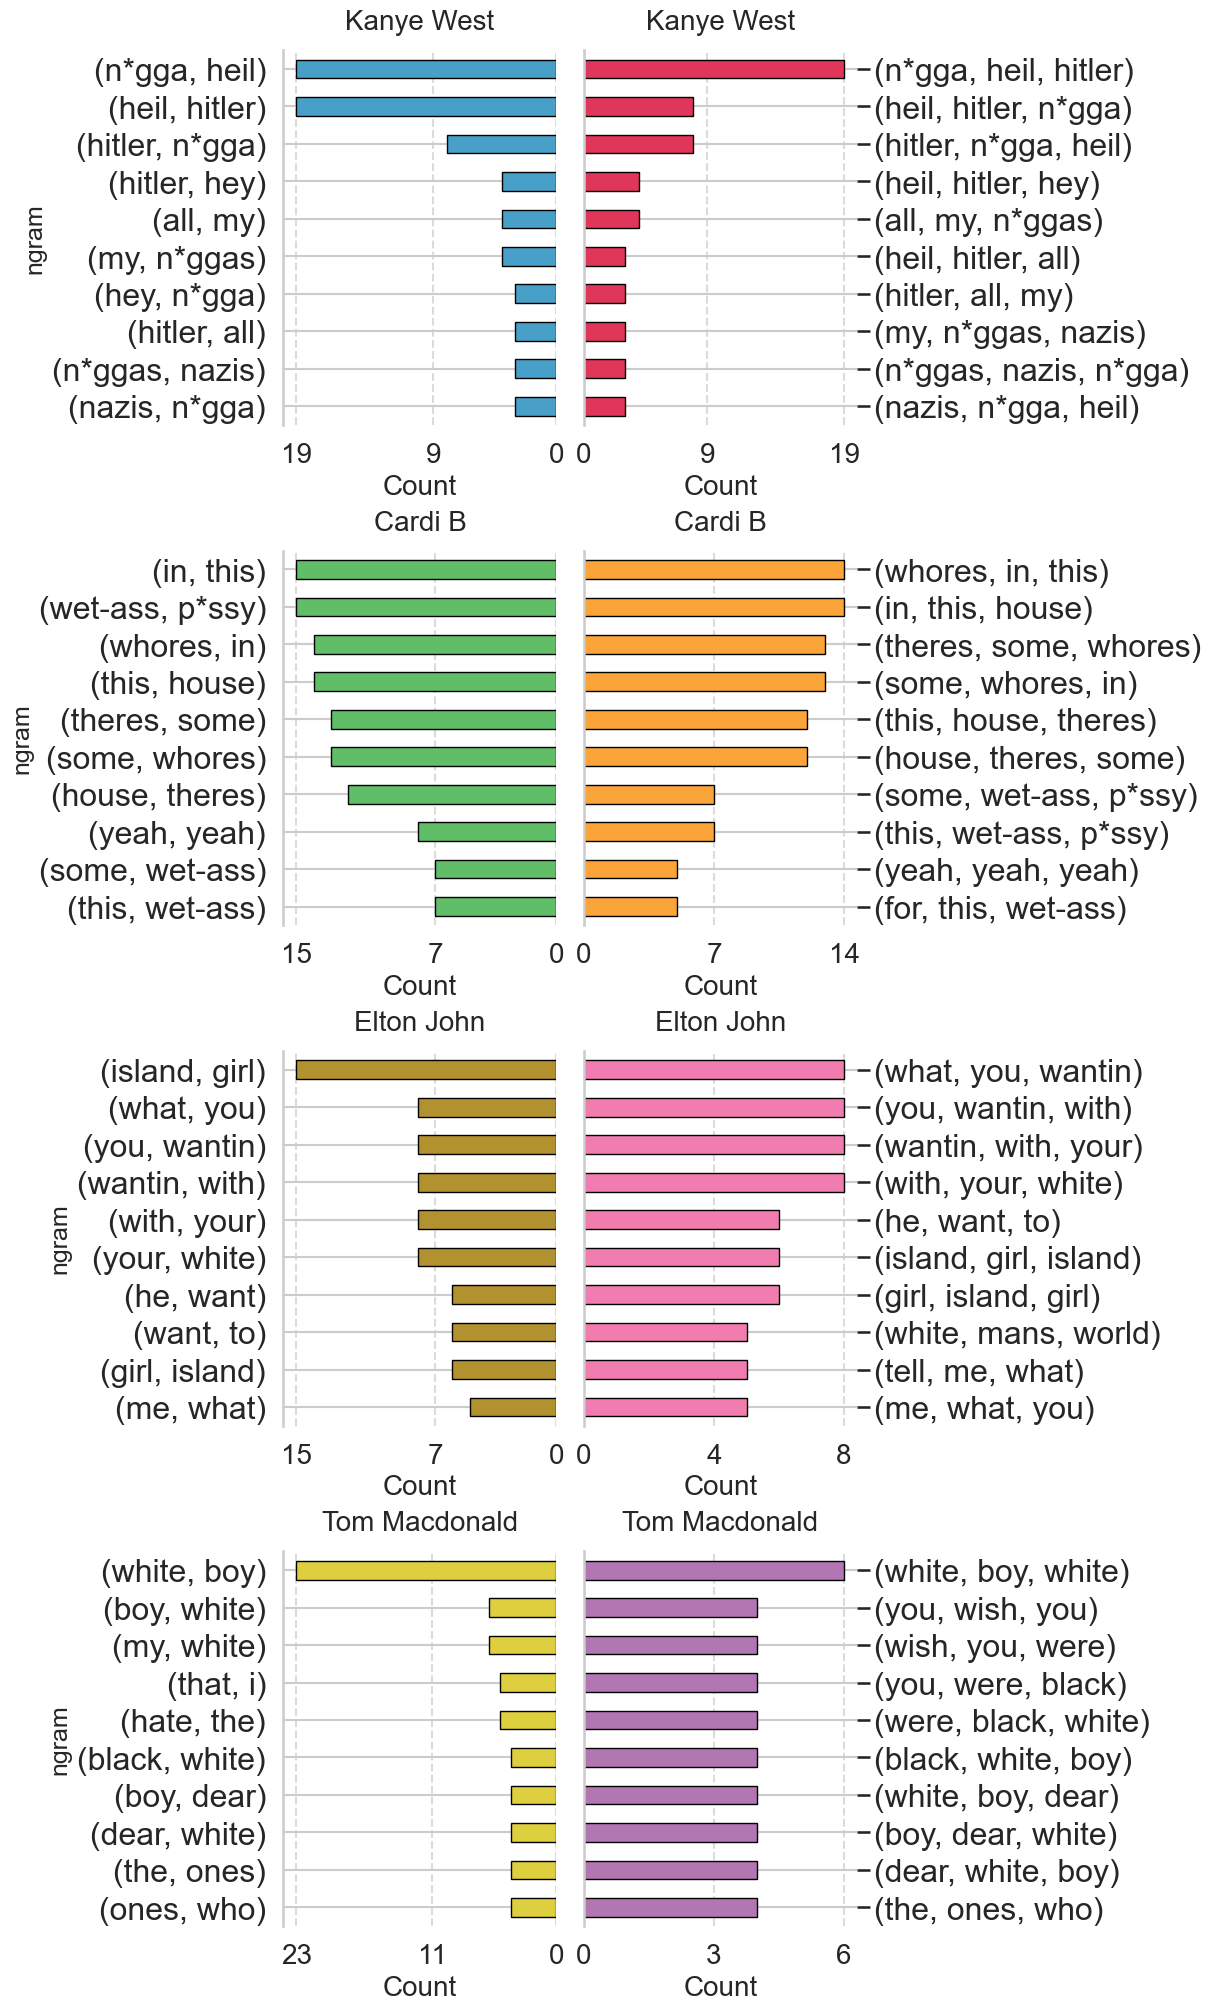

In [140]:
make_artist_ngram_plot(top_ngrams)


In [141]:
def preprocess_lines(lyrics):
    
    lines = lyrics.split("\n")
    lines = [x for x in lines if x != ""]
    return lines

In [142]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

In [143]:
def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class




In [144]:
from transformers import pipeline
sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [145]:
# DistilBERT base uncased finetuned SST-2
line_sentiment = pd.DataFrame(columns=["line", "sentiment", "section", "artist"])
artist_lyric = read_lyrics().items()

for artist, lyric in artist_lyric:
    current_section = None
    for line in preprocess_lines(lyric):
        if line.startswith("[") and line.endswith("]"):
            raw_section = line.strip("[]").strip()
            lower = raw_section.lower()

            # Use regex to match general section types
            if re.match(r"^verse(\b|:)", lower):
                current_section = "Verse"
            elif re.match(r"^(post-)?chorus(\b|:)", lower):
                current_section = "Chorus"
            elif re.match(r"^(intro|outro)(\b|:)", lower):
                current_section = "Chorus"
            elif re.match(r"^bridge(\b|:)", lower):
                current_section = "Verse"
            else:
                current_section = None  # Unrecognized section, skip
            continue  # Skip the section label line itself

        if current_section is None:
            continue  # Skip lines not under a valid section

        s = 1 if sentiment(line)[0]['label'] == "NEGATIVE" else 0
        row = pd.DataFrame([[line, s, current_section, artist]], columns=line_sentiment.columns)
        line_sentiment = pd.concat([line_sentiment, row], ignore_index=True)


In [146]:
line_sentiment

,line,sentiment,section,artist
0,"Man, these people took my kids from me, then t...",1,Verse,Kanye West
1,"I got so much anger in me, got no way to take ...",1,Verse,Kanye West
2,"Think I'm stuck in The Matrix, where the fuck'...",1,Verse,Kanye West
3,"Yes, I am a cuck, I like when people fuck on m...",0,Verse,Kanye West
4,"The shit that I'm posting on Twitter, they tel...",1,Verse,Kanye West
...,...,...,...,...
235,Don't tell me how to see it through my white eyes,1,Chorus,Tom Macdonald
236,"White boy, don't say that",1,Chorus,Tom Macdonald
237,"White boy, oh, you so bad",1,Chorus,Tom Macdonald
238,"White boy, you wish you were black",1,Chorus,Tom Macdonald


In [147]:
line_sentiment['line_number'] = line_sentiment.groupby("artist").cumcount()+1

In [148]:
line_sentiment

,line,sentiment,section,artist,line_number
0,"Man, these people took my kids from me, then t...",1,Verse,Kanye West,1
1,"I got so much anger in me, got no way to take ...",1,Verse,Kanye West,2
2,"Think I'm stuck in The Matrix, where the fuck'...",1,Verse,Kanye West,3
3,"Yes, I am a cuck, I like when people fuck on m...",0,Verse,Kanye West,4
4,"The shit that I'm posting on Twitter, they tel...",1,Verse,Kanye West,5
...,...,...,...,...,...
235,Don't tell me how to see it through my white eyes,1,Chorus,Tom Macdonald,88
236,"White boy, don't say that",1,Chorus,Tom Macdonald,89
237,"White boy, oh, you so bad",1,Chorus,Tom Macdonald,90
238,"White boy, you wish you were black",1,Chorus,Tom Macdonald,91


In [149]:
line_sentiment.to_csv("./data/lines.csv")

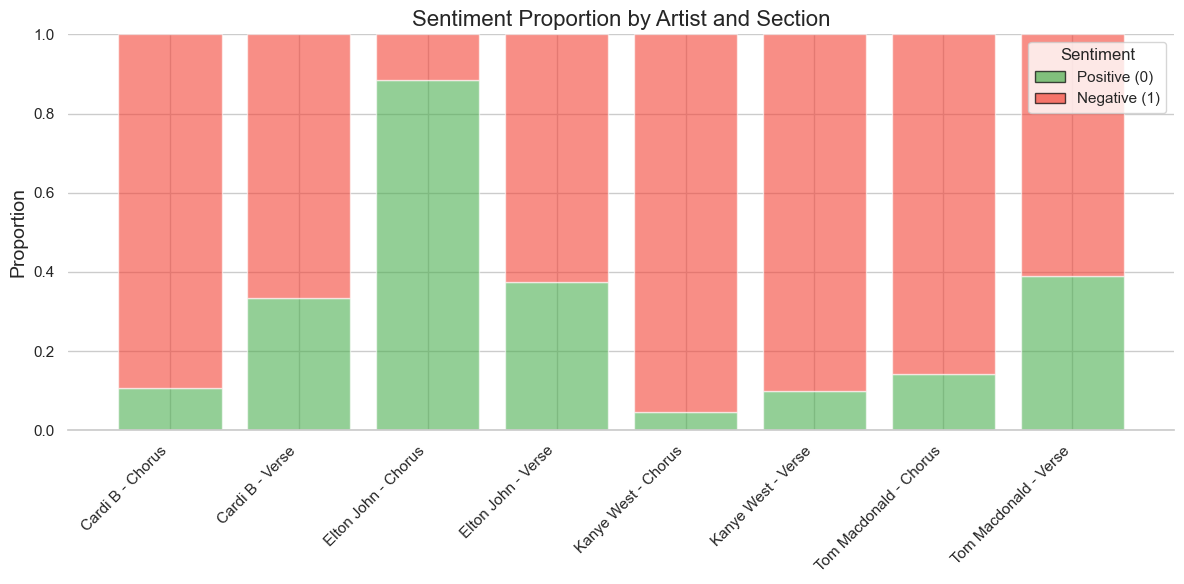

In [ ]:
def adjust_lightness(color, amount=1.0):
    """
    Lighten or darken a matplotlib color.

    amount < 1 → darker
    amount > 1 → lighter
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    rgb = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    new_rgb = colorsys.hls_to_rgb(h, max(0, min(1, l * amount)), s)
    return new_rgb


In [157]:
artist_base_colors = {
    "Kanye West": "#1f77b4",      # blue
    "Cardi B":    "#ff7f0e",      # orange
    "Elton John": "#2ca02c",      # green
    "Tom Macdonald": "#d62728"    # red
}
def adjust_lightness(color, amount=1.0):
    """
    Lighten or darken a matplotlib color.

    amount < 1 → darker
    amount > 1 → lighter
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    rgb = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    new_rgb = colorsys.hls_to_rgb(h, max(0, min(1, l * amount)), s)
    return new_rgb


section_shades = {
    "Verse": 1.3,   # lighter
    "Chorus": 0.7,  # darker
    "Intro": 1.2,
    "Outro": 0.8
}




In [158]:
df = line_sentiment.copy()
df["sentiment"] = pd.to_numeric(df["sentiment"], errors="coerce")
df = df.sort_values(["artist", "line_number"])
df["cum_lines"] = df.groupby("artist").cumcount() + 1
df["cumulative_neg"] = df.groupby("artist")["sentiment"].cumsum()
df["cumulative_neg_prop"] = df["cumulative_neg"] / df["cum_lines"]

C:\Users\jiyon\AppData\Local\Temp\ipykernel_20376\41728055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_data["section_shifted"] = artist_data["section"].shift(1, fill_value=None)
C:\Users\jiyon\AppData\Local\Temp\ipykernel_20376\41728055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_data["section_shifted"] = artist_data["section"].shift(1, fill_value=None)
C:\Users\jiyon\AppData\Local\Temp\ipykernel_20376\41728055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a 

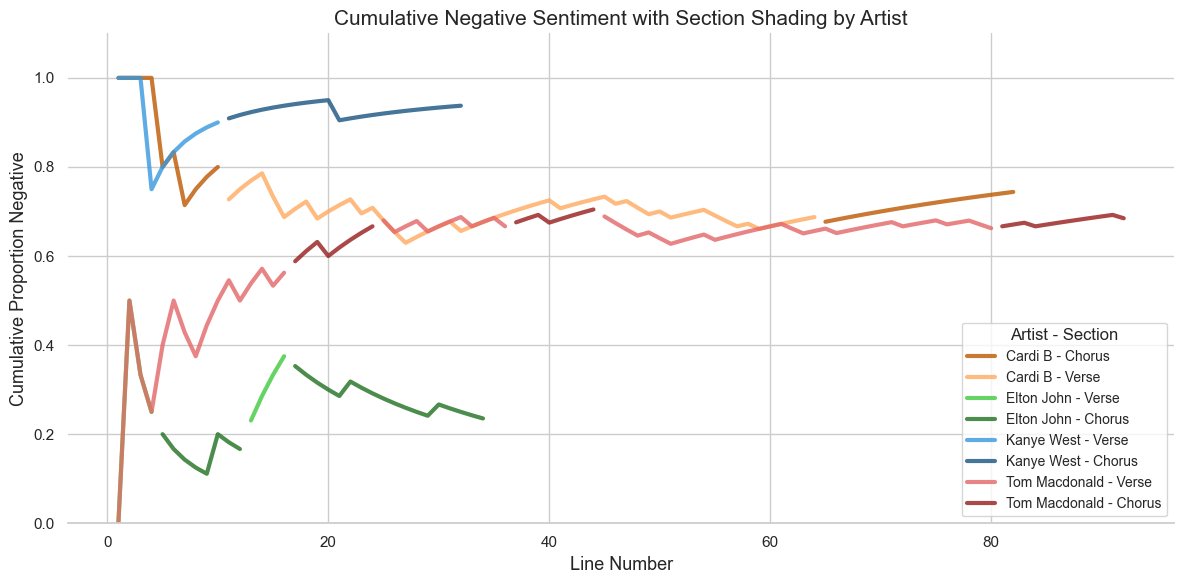

In [163]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

for artist in df["artist"].unique():
    artist_data = df[df["artist"] == artist]
    
    base_color = artist_base_colors.get(artist, "grey")
    
    # Find section change indices
    artist_data["section_shifted"] = artist_data["section"].shift(1, fill_value=None)
    change_points = artist_data[
        artist_data["section"] != artist_data["section_shifted"]
    ].index.tolist()
    
    # Append final index IF necessary
    if len(change_points) == 0:
        # No change at all → entire artist_data is one section
        change_points = [artist_data.index[0]]
        change_points.append(artist_data.index[-1] + 1)
    elif change_points[-1] != artist_data.index[-1] + 1:
        change_points.append(artist_data.index[-1] + 1)

    # Plot all segments
    for i in range(len(change_points)-1):
        start_idx = change_points[i]
        end_idx = change_points[i+1]
        
        chunk = artist_data.loc[start_idx:end_idx - 1]
        
        if chunk.empty:
            continue
        
        section = chunk["section"].iloc[0]
        
        shade_factor = section_shades.get(section, 1.0)
        color = adjust_lightness(base_color, shade_factor)
        
        plt.plot(
            chunk["line_number"],
            chunk["cumulative_neg_prop"],
            color=color,
            linewidth=3,
            alpha=0.8,
            label=f"{artist} - {section}"
        )

# Clean legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=10, title="Artist - Section")

plt.xlabel("Line Number", fontsize=13)
plt.ylabel("Cumulative Proportion Negative", fontsize=13)
plt.title("Cumulative Negative Sentiment with Section Shading by Artist", fontsize=15)
plt.ylim(0, 1.1)
sns.despine(left=True)
plt.tight_layout()
plt.show()
